Implemente os classificadores k-NN, com e sem peso, e o k-NN adaptativo; use distância Euclidiana. Avalie os três classificadores em duas bases de dados do repositório Promise (ver link abaixo). Essas bases devem conter apenas atributos numéricos. Varie o parâmetro k = {1,2,3,5,7,9,11,13,15} e construa um gráfico que mostre o comportamento da taxa de acerto à medida que o valor de k muda para os três classificadores. Analise os resultados em relação ao tempo de processamento e à taxa de acerto, e construa uma argumentação que indique as melhores escolhas para as bases de dados avaliadas. (dica: observe o valor de k, o acerto/erro por classe, o tempo de treinamento e o tempo de teste).

Promise repository: http://promise.site.uottawa.ca/SERepository/datasets-page.html. Na avaliação dos algoritmos, use o k-fold cross-validation. O relatório deve conter informações de forma que seja possível replicar os experimentos (metodologia dos experimentos), além dos resultados e suas análises.

In [13]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import time

variacoes_k = [1,2,3,5,7,9,11,13,15]
SEED = 5
np.random.seed(SEED)

# prepara o procedimento cross-validation
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [14]:
def knnSemPeso(treino_x, treino_y, teste_x, teste_y):
    taxasAcertoSemPeso = pd.DataFrame(columns=['k', 'acuracia'])
    for k in variacoes_k:
        neigh = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')

        inicioTreino = time.time()
        neigh.fit(treino_x, treino_y)
        fimTreino = time.time()
        tempoTreino = fimTreino - inicioTreino

        inicioTeste = time.time()
        previsoes = neigh.predict(teste_x)
        fimTeste = time.time()
        tempoTeste = fimTeste - inicioTeste

        #calculando a acuracia
        acuracia = np.mean(cross_val_score(neigh, teste_x, teste_y, cv=cv))
        taxasAcertoSemPeso.loc[k] = [k, acuracia]
        print(f"A acurácia com k={k} foi %.2f%%" % (acuracia * 100))
        print("Tempo de treino: %.4g s" % tempoTreino)
        print("Tempo de teste: %.4g s" % tempoTeste)

    print(taxasAcertoSemPeso)
    plt.plot(taxasAcertoSemPeso['k'],taxasAcertoSemPeso['acuracia'])
    plt.title("Acurácia KNN sem peso")
    plt.grid(True)
    plt.xlabel("Valor de K")
    plt.ylabel("Acurácia")

In [15]:
def knnComPeso(treino_x, treino_y, teste_x, teste_y):
    taxasAcertoComPeso = pd.DataFrame(columns=['k', 'acuracia'])
    for k in variacoes_k:
        neigh = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
        inicioTreino = time.time()
        neigh.fit(treino_x, treino_y)
        fimTreino = time.time()
        tempoTreino = fimTreino - inicioTreino

        inicioTeste = time.time()
        neigh.predict(teste_x)
        fimTeste = time.time()
        tempoTeste = fimTeste - inicioTeste

        #calculando a acuracia
        acuracia = np.mean(cross_val_score(neigh, teste_x, teste_y, cv=cv))
        taxasAcertoComPeso.loc[k] = [k, acuracia]
        print(f"A acurácia com k={k} foi %.2f%%" % (acuracia * 100))
        print("Tempo de treino: %.4g s" % tempoTreino)
        print("Tempo de teste: %.4g s" % tempoTeste)
    print(taxasAcertoComPeso)
    plt.plot(taxasAcertoComPeso['k'],taxasAcertoComPeso['acuracia'])
    plt.title("Acurácia KNN com peso")
    plt.grid(True)
    plt.xlabel("Valor de K")
    plt.ylabel("Acurácia")

In [16]:
#pega a menor distancia usando dist euclidiana e o raio = (y[-1])
def mydist(x, y):
    return np.sqrt(np.sum((x[:-1] - y[:-1]) ** 2)) / y[-1]

def knnAdaptativo(arquivo, colunaClasse):
    taxasAcertoAdaptativo = pd.DataFrame(columns=['k', 'acuracia'])
    for k in variacoes_k:
        df = pd.read_csv(arquivo)
        df[colunaClasse] = df[colunaClasse].apply(lambda x: int(x))
        X, y = df.iloc[:,:-1], df[colunaClasse]
        #Normalizando os dados
        X = (X - X.min()) / (X.max() - X.min())
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

        #Separando a conjunto por Label
        X_train['ALVO'] = y_train
        X_train_1 = X_train[X_train.ALVO == 1]
        X_train_0 = X_train[X_train.ALVO == 0]
        y_train_1, X_train_1 = X_train_1['ALVO'], X_train_1.drop('ALVO', axis=1)
        y_train_0, X_train_0 = X_train_0['ALVO'], X_train_0.drop('ALVO', axis=1)
        #Criando um knn para cada classe
        knn0 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
        knn1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

        #Calculando o raio para classe 0
        knn1.fit(X_train_1, y_train_1)
        distance0, _ = knn1.kneighbors(X_train_0)

        #Calculando o raio para classe 1
        knn0.fit(X_train_0, y_train_0)
        distance1, _ = knn0.kneighbors(X_train_1)

        #salvar o dado no dataframe e pegar depois
        X_train_0['raio'] = distance0.flatten()
        X_train_1['raio'] = distance1.flatten()
        X_train = pd.concat([X_train_0, X_train_1])

        knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric=mydist)

        # o raio só está no conjunto de treino, então usei o zeros para ter o mesmo Shape que o conjunto de treino que contem os raios
        X_test.loc[:, 'dist'] = np.zeros(X_test.shape[0])
        inicioTreino = time.time()
        knn.fit(X_train, y_train)
        fimTreino = time.time()
        tempoTreino = fimTreino - inicioTreino

        inicioTeste = time.time()
        X_test.loc[:, 'pred'] = knn.predict(X_test)
        acuracia = (X_test['pred'] == y_test).mean()
        fimTeste = time.time()
        tempoTeste = fimTeste - inicioTeste

        taxasAcertoAdaptativo.loc[k] = [k, acuracia]
        print(f"A acurácia com k={k} foi %.2f%%" % (acuracia * 100))
        print("Tempo de treino: %.4g s" % tempoTreino)
        print("Tempo de teste: %.4g s" % tempoTeste)

    print(taxasAcertoAdaptativo)
    plt.plot(taxasAcertoAdaptativo['k'],taxasAcertoAdaptativo['acuracia'])
    plt.title("Acurácia KNN adaptativo")
    plt.grid(True)
    plt.xlabel("Valor de K")
    plt.ylabel("Acurácia")

# Dataset **KC1/Software defect prediction**

Title/Topic: KC1/Software defect prediction

Donor: Tim Menzies (tim@barmag.net)

Date: December 2, 2004

Sources:

Creators:
NASA, then the NASA Metrics Data Program,
http://mdp.ivv.nasa.gov.

In [17]:
kc1Dataset = pd.read_csv('datasets/kc1.csv')
kc1Dataset = kc1Dataset.drop_duplicates()
kc1Dataset.head()

# tratando os dados
kc1Dataset['problems'] = kc1Dataset['problems'].astype(int)
print(kc1Dataset.head())

x = kc1Dataset.loc[:, kc1Dataset.columns != 'problems']
#normalizando valores
x= (x - x.min()) / (x.max() - x.min())
y = kc1Dataset['problems']
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))


    loc  v(g)  ev(g)  iv(g)      n       v     l      d      i         e  \
0   1.1   1.4    1.4    1.4    1.3    1.30  1.30   1.30   1.30      1.30   
1   1.0   1.0    1.0    1.0    1.0    1.00  1.00   1.00   1.00      1.00   
2  83.0  11.0    1.0   11.0  171.0  927.89  0.04  23.04  40.27  21378.61   
3  46.0   8.0    6.0    8.0  141.0  769.78  0.07  14.86  51.81  11436.73   
4  25.0   3.0    1.0    3.0   58.0  254.75  0.11   9.35  27.25   2381.95   

      b        t  lOCode  lOComment  lOBlank  lOCodeAndComment  uniq_Op  \
0  1.30     1.30       2          2        2                 2      1.2   
1  1.00     1.00       1          1        1                 1      1.0   
2  0.31  1187.70      65         10        6                 0     18.0   
3  0.26   635.37      37          2        5                 0     16.0   
4  0.08   132.33      21          0        2                 0     11.0   

   uniq_Opnd  total_Op  total_Opnd  branchCount  problems  
0        1.2       1.2         1

A acurácia com k=1 foi 66.34%
Tempo de treino: 0.001513 s
Tempo de teste: 0.02339 s
A acurácia com k=2 foi 73.62%
Tempo de treino: 0.002377 s
Tempo de teste: 0.01462 s
A acurácia com k=3 foi 72.31%
Tempo de treino: 0.003158 s
Tempo de teste: 0.02387 s
A acurácia com k=5 foi 74.61%
Tempo de treino: 0.00422 s
Tempo de teste: 0.05207 s
A acurácia com k=7 foi 74.28%
Tempo de treino: 0.002882 s
Tempo de teste: 0.03019 s
A acurácia com k=9 foi 73.61%
Tempo de treino: 0.002938 s
Tempo de teste: 0.02545 s
A acurácia com k=11 foi 74.61%
Tempo de treino: 0.003129 s
Tempo de teste: 0.02623 s
A acurácia com k=13 foi 73.95%
Tempo de treino: 0.002906 s
Tempo de teste: 0.02681 s
A acurácia com k=15 foi 73.94%
Tempo de treino: 0.002755 s
Tempo de teste: 0.02648 s
       k  acuracia
1    1.0  0.663388
2    2.0  0.736175
3    3.0  0.723060
5    5.0  0.746120
7    7.0  0.742787
9    9.0  0.736120
11  11.0  0.746120
13  13.0  0.739454
15  15.0  0.739399


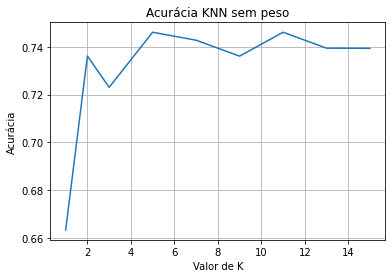

In [18]:
knnSemPeso(treino_x, treino_y, teste_x, teste_y)

A acurácia com k=1 foi 66.34%
Tempo de treino: 0.00163 s
Tempo de teste: 0.006237 s
A acurácia com k=2 foi 66.34%
Tempo de treino: 0.003204 s
Tempo de teste: 0.007959 s
A acurácia com k=3 foi 71.97%
Tempo de treino: 0.002722 s
Tempo de teste: 0.009118 s
A acurácia com k=5 foi 73.30%
Tempo de treino: 0.002673 s
Tempo de teste: 0.01002 s
A acurácia com k=7 foi 75.61%
Tempo de treino: 0.002796 s
Tempo de teste: 0.01335 s
A acurácia com k=9 foi 73.95%
Tempo de treino: 0.002723 s
Tempo de teste: 0.01008 s
A acurácia com k=11 foi 75.27%
Tempo de treino: 0.002753 s
Tempo de teste: 0.01085 s
A acurácia com k=13 foi 75.28%
Tempo de treino: 0.002735 s
Tempo de teste: 0.0105 s
A acurácia com k=15 foi 75.60%
Tempo de treino: 0.003229 s
Tempo de teste: 0.01171 s
       k  acuracia
1    1.0  0.663388
2    2.0  0.663388
3    3.0  0.719727
5    5.0  0.732951
7    7.0  0.756066
9    9.0  0.739508
11  11.0  0.752732
13  13.0  0.752787
15  15.0  0.755956


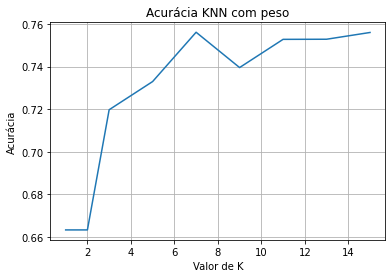

In [19]:
knnComPeso(treino_x, treino_y, teste_x, teste_y)


<ipython-input-16-a6296eb30580>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ALVO'] = y_train
/home/victor/projetos/lista1-if699-ml/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/victor/projetos/lista1-if699-ml/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

A acurácia com k=1 foi 75.19%
Tempo de treino: 0.1596 s
Tempo de teste: 5.566 s
A acurácia com k=2 foi 83.90%
Tempo de treino: 0.1609 s
Tempo de teste: 5.516 s
A acurácia com k=3 foi 70.08%
Tempo de treino: 0.1604 s
Tempo de teste: 5.283 s
A acurácia com k=5 foi 83.52%
Tempo de treino: 0.1619 s
Tempo de teste: 5.218 s
A acurácia com k=7 foi 83.14%
Tempo de treino: 0.1618 s
Tempo de teste: 5.411 s
A acurácia com k=9 foi 83.52%
Tempo de treino: 0.164 s
Tempo de teste: 5.505 s
A acurácia com k=11 foi 84.47%
Tempo de treino: 0.1799 s
Tempo de teste: 6 s
A acurácia com k=13 foi 84.47%
Tempo de treino: 0.1791 s
Tempo de teste: 5.797 s
A acurácia com k=15 foi 84.47%
Tempo de treino: 0.1792 s
Tempo de teste: 5.474 s
       k  acuracia
1    1.0  0.751894
2    2.0  0.839015
3    3.0  0.700758
5    5.0  0.835227
7    7.0  0.831439
9    9.0  0.835227
11  11.0  0.844697
13  13.0  0.844697
15  15.0  0.844697


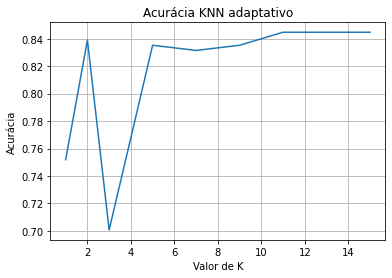

In [20]:
knnAdaptativo('datasets/kc1.csv', 'problems')

# Dataset **CM1/Software defect prediction**

Title/Topic: CM1/Software defect prediction

Donor: Tim Menzies (tim@barmag.net)

Date: December 2, 2004

Sources:

Creators:
NASA, then the NASA Metrics Data Program,
http://mdp.ivv.nasa.gov.

In [21]:
cm1Dataset = pd.read_csv('datasets/cm1.csv')
cm1Dataset.head()

# tratando os dados
cm1Dataset['defects'] = cm1Dataset['defects'].astype(int)
cm1Dataset.head()

x = cm1Dataset.loc[:, cm1Dataset.columns != 'defects']
x= (x - x.min()) / (x.max() - x.min())
print(x.head())
y = cm1Dataset['defects']

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

        loc      v(g)     ev(g)     iv(g)         n         v         l  \
0  0.000237  0.004211  0.013793  0.006452  0.000145  0.000076  1.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000058  0.769231   
2  0.054502  0.042105  0.000000  0.032258  0.029894  0.018052  0.084615   
3  0.045024  0.031579  0.103448  0.016129  0.022179  0.012584  0.046154   
4  0.054502  0.052632  0.172414  0.016129  0.034233  0.020213  0.046154   

          d         i             e         b         t  lOCode  lOComment  \
0  0.010336  0.004427  6.036150e-07  0.227671  0.000011  0.0250    0.00590   
1  0.007951  0.003405  4.643192e-07  0.175131  0.000008  0.0125    0.00295   
2  0.075535  0.110801  1.363599e-03  0.017513  0.001364  0.0125    0.00000   
3  0.127216  0.045866  1.600922e-03  0.012259  0.001601  0.0000    0.00000   
4  0.137791  0.067999  2.785720e-03  0.021016  0.002786  0.0000    0.00000   

    lOBlank  lOCodeAndComment   uniq_Op  uniq_Opnd  total_Op  total_Opnd  \
0  0

A acurácia com k=1 foi 84.80%
Tempo de treino: 0.001495 s
Tempo de teste: 0.01051 s
A acurácia com k=2 foi 88.00%
Tempo de treino: 0.003312 s
Tempo de teste: 0.01375 s
A acurácia com k=3 foi 84.80%
Tempo de treino: 0.003481 s
Tempo de teste: 0.01346 s
A acurácia com k=5 foi 87.20%
Tempo de treino: 0.006908 s
Tempo de teste: 0.01564 s
A acurácia com k=7 foi 89.60%
Tempo de treino: 0.003976 s
Tempo de teste: 0.0161 s
A acurácia com k=9 foi 89.60%
Tempo de treino: 0.005287 s
Tempo de teste: 0.01782 s
A acurácia com k=11 foi 90.40%
Tempo de treino: 0.004505 s
Tempo de teste: 0.02047 s
A acurácia com k=13 foi 90.40%
Tempo de treino: 0.005281 s
Tempo de teste: 0.0213 s
A acurácia com k=15 foi 90.40%
Tempo de treino: 0.004358 s
Tempo de teste: 0.01839 s
       k  acuracia
1    1.0     0.848
2    2.0     0.880
3    3.0     0.848
5    5.0     0.872
7    7.0     0.896
9    9.0     0.896
11  11.0     0.904
13  13.0     0.904
15  15.0     0.904


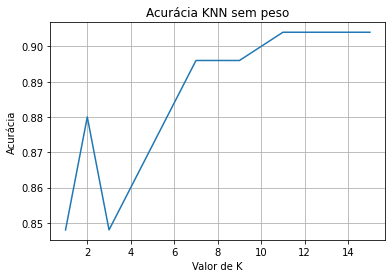

In [22]:
knnSemPeso(treino_x, treino_y, teste_x, teste_y)

A acurácia com k=1 foi 84.80%
Tempo de treino: 0.001988 s
Tempo de teste: 0.005768 s
A acurácia com k=2 foi 84.80%
Tempo de treino: 0.004688 s
Tempo de teste: 0.005928 s
A acurácia com k=3 foi 84.80%
Tempo de treino: 0.004484 s
Tempo de teste: 0.008116 s
A acurácia com k=5 foi 87.20%
Tempo de treino: 0.004055 s
Tempo de teste: 0.006923 s
A acurácia com k=7 foi 89.60%
Tempo de treino: 0.004237 s
Tempo de teste: 0.007437 s
A acurácia com k=9 foi 89.60%
Tempo de treino: 0.004183 s
Tempo de teste: 0.01587 s
A acurácia com k=11 foi 90.40%
Tempo de treino: 0.004146 s
Tempo de teste: 0.0139 s
A acurácia com k=13 foi 90.40%
Tempo de treino: 0.004418 s
Tempo de teste: 0.008737 s
A acurácia com k=15 foi 90.40%
Tempo de treino: 0.004139 s
Tempo de teste: 0.008135 s
       k  acuracia
1    1.0     0.848
2    2.0     0.848
3    3.0     0.848
5    5.0     0.872
7    7.0     0.896
9    9.0     0.896
11  11.0     0.904
13  13.0     0.904
15  15.0     0.904


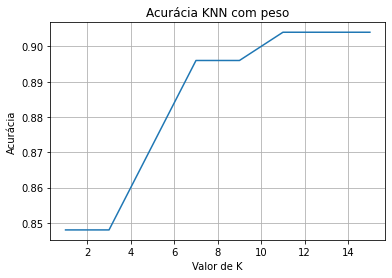

In [23]:
knnComPeso(treino_x, treino_y, teste_x, teste_y)

<ipython-input-16-a6296eb30580>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ALVO'] = y_train
/home/victor/projetos/lista1-if699-ml/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/victor/projetos/lista1-if699-ml/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

A acurácia com k=1 foi 80.00%
Tempo de treino: 0.01779 s
Tempo de teste: 0.4986 s
A acurácia com k=2 foi 89.60%
Tempo de treino: 0.01444 s
Tempo de teste: 0.4179 s
A acurácia com k=3 foi 89.60%
Tempo de treino: 0.01357 s
Tempo de teste: 0.4218 s
A acurácia com k=5 foi 90.40%
Tempo de treino: 0.01568 s
Tempo de teste: 0.3612 s
A acurácia com k=7 foi 90.40%
Tempo de treino: 0.01449 s
Tempo de teste: 0.4274 s
A acurácia com k=9 foi 90.40%
Tempo de treino: 0.01396 s
Tempo de teste: 0.4063 s
A acurácia com k=11 foi 90.40%
Tempo de treino: 0.01336 s
Tempo de teste: 0.425 s
A acurácia com k=13 foi 90.40%
Tempo de treino: 0.01351 s
Tempo de teste: 0.4284 s
A acurácia com k=15 foi 90.40%
Tempo de treino: 0.01359 s
Tempo de teste: 0.4088 s
       k  acuracia
1    1.0     0.800
2    2.0     0.896
3    3.0     0.896
5    5.0     0.904
7    7.0     0.904
9    9.0     0.904
11  11.0     0.904
13  13.0     0.904
15  15.0     0.904


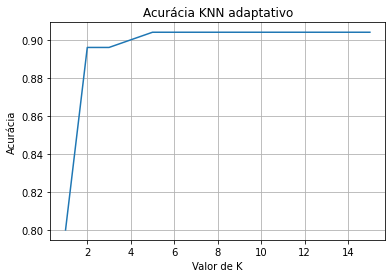

In [24]:
knnAdaptativo('datasets/cm1.csv', 'defects')